In [ ]:
# SET HERE YOUR WORKING PATH to the shared directory SL_Project
path_chiara = '/content/drive/MyDrive/POLIMI/StatLearn/SL_Project'
path_due = '/content/drive/MyDrive/SL_Project'

path = path_chiara

Pre-ops
---


### Mount google drive
Before starting We need to connect the Google Drive storage to the notebook. We can mount google drive by using the google colab api. Then, we create a shortcut to drive's folder. 

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

# Insert here the path of the working folder
os.chdir(path)

# Check the currect working directory
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/POLIMI/StatLearn/SL_Project'

###Import libraries

In [ ]:
!pip install lime

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import lime
from lime.lime_tabular import LimeTabularExplainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=99ee4038a0cabb8f32dd5aec2ceea8d4049e397aed5403fc49998979d4b90df0
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip3 install shap
import time
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 11.1 MB/s eta 0:00:00


In [ ]:

# !pip install pdpbox
# from pdpbox import pdp, get_dataset, info_plots

# Utils

In [ ]:
def compute_metrics(y_train,pred_train,y_test, pred_test):
  train_accuracy = accuracy_score(y_train, pred_train)
  train_f1 = f1_score(y_train, pred_train)
  train_precision = precision_score(y_train, pred_train)
  train_recall = recall_score(y_train, pred_train)
  train_confusion = confusion_matrix(y_train, pred_train)
  train_confusion = train_confusion.astype('float') / train_confusion.sum(axis=1)[:, np.newaxis]

  test_accuracy = accuracy_score(y_test, pred_test)
  test_f1 = f1_score(y_test, pred_test)
  test_precision = precision_score(y_test, pred_test)
  test_recall = recall_score(y_test, pred_test)
  test_confusion = confusion_matrix(y_test, pred_test)
  test_confusion = test_confusion.astype('float') / test_confusion.sum(axis=1)[:, np.newaxis]

  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  sns.heatmap(train_confusion, annot=True, linewidths = 0.01, ax = axes[0])
  axes[0].set_title("Confusion Matrix (Training Set)")
  axes[0].set_xlabel("Predicted Labels")
  axes[0].set_ylabel("True Labels")
  sns.heatmap(test_confusion, annot=True, linewidths = 0.01, ax = axes[1])
  axes[1].set_title("Confusion Matrix (Testing Set)")
  axes[1].set_xlabel("Predicted Labels")
  axes[1].set_ylabel("True Labels")
  plt.tight_layout()
  plt.show()

  print("Training Set Metrics:")
  print("Accuracy:", train_accuracy)
  print("F1 Score:", train_f1)
  print("Precision:", train_precision)
  print("Recall:", train_recall)
  print("\nTesting Set Metrics:")
  print("Accuracy:", test_accuracy)
  print("F1 Score:", test_f1)
  print("Precision:", test_precision)
  print("Recall:", test_recall)

# Data loading and preparation

In [ ]:
# Loading data
x_train = pd.read_csv('Data/working_train_2905.csv').drop(['Unnamed: 0'], axis=1)
x_test = pd.read_csv('Data/working_test_2905.csv').drop(['Unnamed: 0'], axis=1)

y_train = pd.read_csv('Data/target_train_2905.csv').drop(['Unnamed: 0'], axis=1).values.flatten()
y_test = pd.read_csv('Data/target_test_2905.csv').drop(['Unnamed: 0'], axis=1).values.flatten()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1576, 43)
(390, 43)
(1576,)
(390,)


In [ ]:
print(f"Datasets have {len(x_train.columns)} columns, which are:\n{x_train.columns}")

Datasets have 43 columns, which are:
Index(['pulse', 'systolic.blood.pressure', 'diastolic.blood.pressure',
       'NYHA.cardiac.function.classification', 'diabetes',
       'moderate.to.severe.chronic.kidney.disease', 'CCI.score', 'fio2',
       'creatinine.enzymatic.method', 'urea', 'uric.acid',
       'glomerular.filtration.rate', 'red.blood.cell',
       'coefficient.of.variation.of.red.blood.cell.distribution.width',
       'standard.deviation.of.red.blood.cell.distribution.width',
       'basophil.ratio', 'basophil.count', 'neutrophil.ratio',
       'international.normalized.ratio',
       'activated.partial.thromboplastin.time', 'prothrombin.activity',
       'carbon.dioxide.binding.capacity', 'potassium', 'sodium',
       'glutamic.pyruvic.transaminase', 'cholesterol', 'dischargeDay',
       'Furosemide tablet', 'Meglumine Adenosine Cyclophosphate for injection',
       'Furosemide injection', 'Milrinone injection', 'Deslanoside injection',
       'Torasemide tablet', 'Digoxin 

#EXPLAINABILITY
→ For linear models we can evaluate magnitude and direction of each coefficient

→ For non-linear models we can use:

* **SHapley Additive exPlanations (SHAP)**
It is an framework to get insights into how individual features contribute to the predictions of a machine learning model based on the concept of Shapley values from cooperative game theory.The basic idea behind SHAP is to assign a contribution value to each feature, indicating its impact on the model's output. These contributions are computed by considering different subsets of features and measuring their influence on the prediction.
(From Shapley sampling values: Strumbelj, Erik, and Igor Kononenko. "Explaining prediction models and individual predictions with feature contributions." Knowledge and information systems 41.3 (2014): 647-665. ; https://shap.readthedocs.io/en/latest/index.html )

*   **LIME (Local Interpretable Model-agnostic Explanations)**
It is a framework that provide explanantions as local linear approximation of the model's behaviour. This is performed to simplify the map the hard task of interpreting complex models to a simplest and model agnostic one.  
(From https://github.com/marcotcr/lime)

*   **Partial Dependence Plots**: Visualization frameworks to show how prediction changes when a *single variable* changes keepeing the others constant. 

*   **Features shuffling**: values of a single variable are shuffled and variation of performances is evaluated. 











Preliminatory steps to set the explainability frameworks, regardless the model to be explained:

In [ ]:
# LIME 
explainer_lime = LimeTabularExplainer(x_train.values, feature_names = x_train.columns.tolist(), class_names = [0,1], mode = 'classification')

# SHAPE 
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(x_train, 10)

def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(x_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


# Linear models

In [ ]:
# Get the model
model_path = 'models/LR_C1.0.pkl'
with open(model_path, 'rb') as file:  model = pickle.load(file)

pred_train = model.predict(x_train) 
pred_test = model.predict(x_test) 

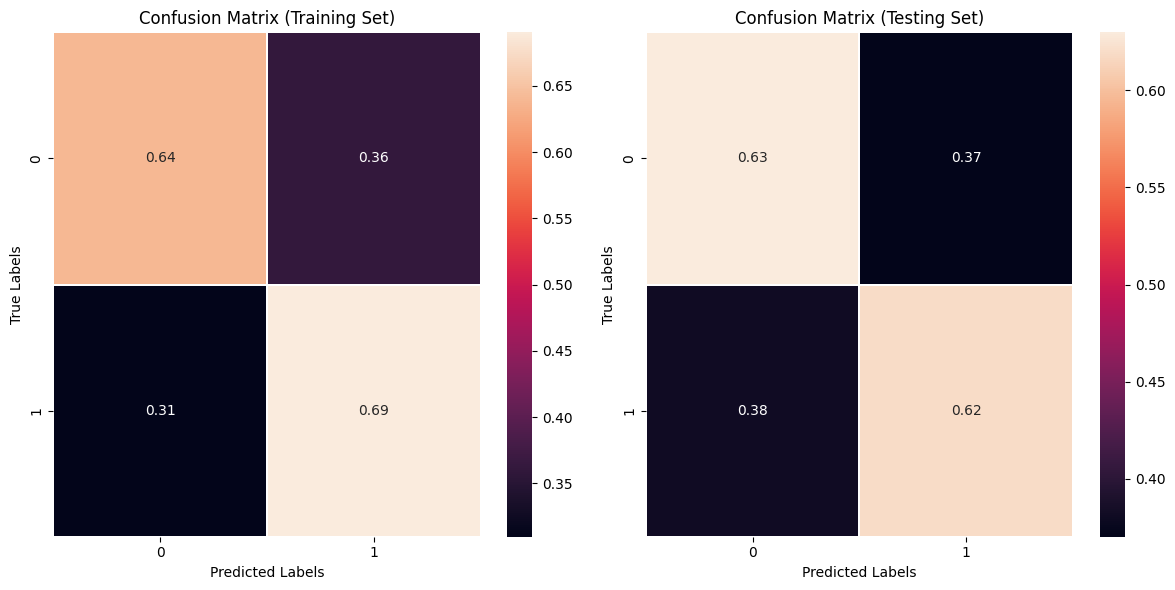

Training Set Metrics:
Accuracy: 0.6643401015228426
F1 Score: 0.6728509585652444
Precision: 0.6562123039806996
Recall: 0.6903553299492385

Testing Set Metrics:
Accuracy: 0.6256410256410256
F1 Score: 0.5680473372781066
Precision: 0.5245901639344263
Recall: 0.6193548387096774


In [ ]:
compute_metrics(y_train,pred_train,y_test, pred_test)

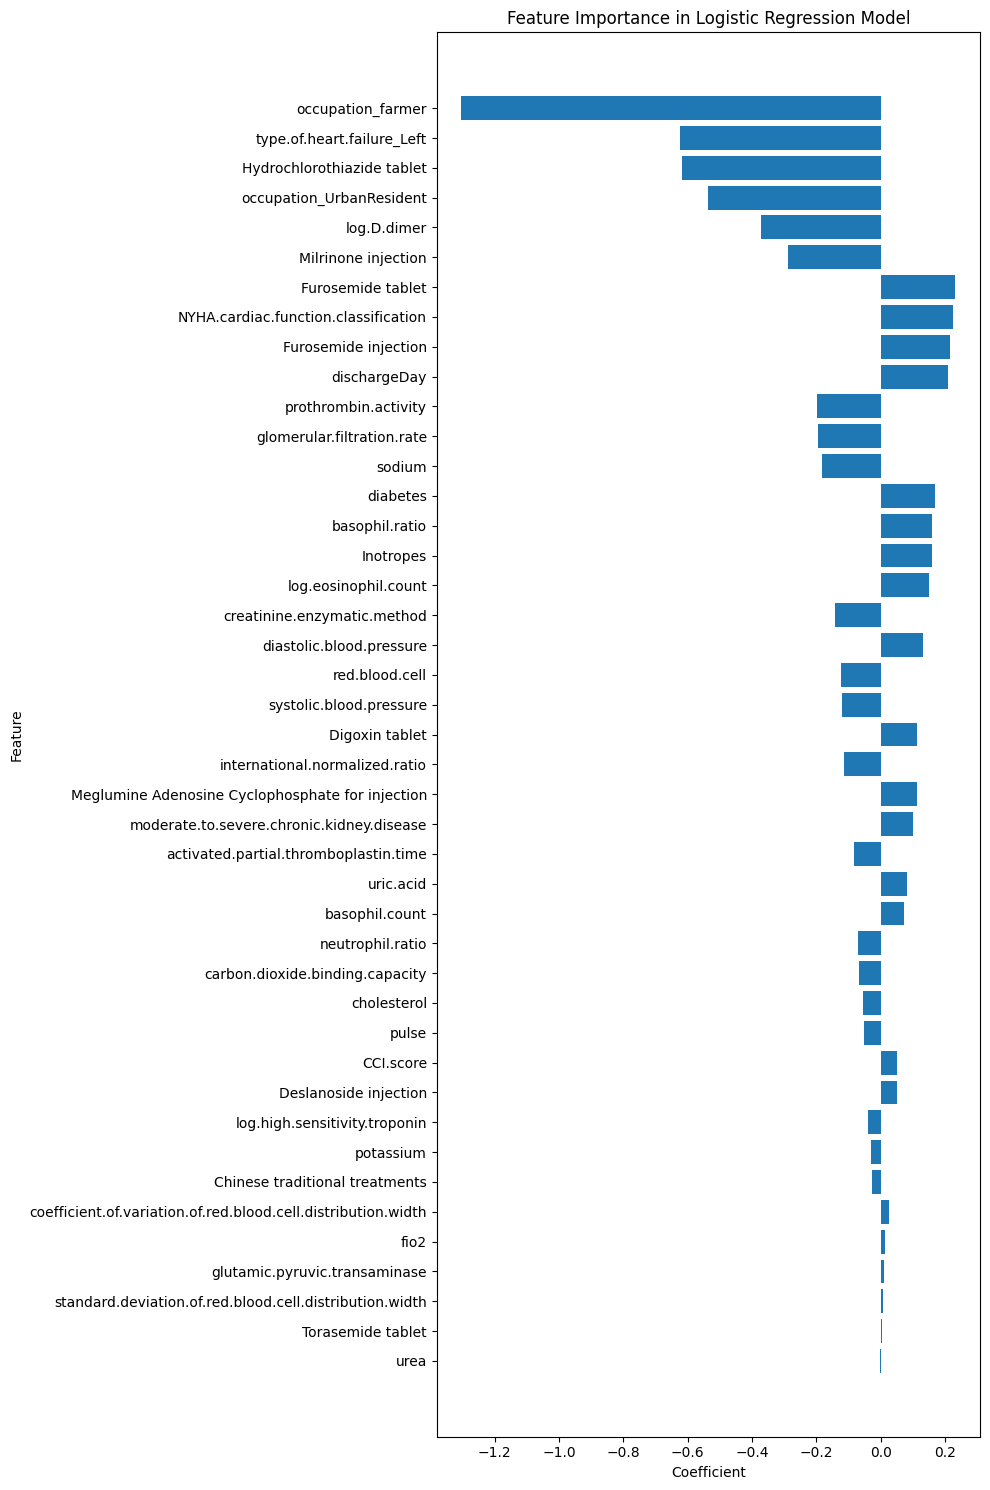

In [ ]:
# Analyze feature importance

# Get the coefficients and feature names
coefficients = model.coef_[0]
feature_names = x_train.columns

# Sort the coefficients in descending order of magnitude
sorted_indices = np.argsort(np.abs(coefficients))
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 15))
plt.barh(range(len(sorted_feature_names)), sorted_coefficients, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Model')
plt.tight_layout()
plt.show()

# Ensemble

In [ ]:
# Get the model
model_path = 'models/ensemble_soft.pkl'
with open(model_path, 'rb') as file:  model = pickle.load(file)

### SHAP

In [ ]:
i = 82
#x_test_ = x_test.iloc[i-10:i+10,:]
x_test_ = x_test

In [ ]:
# explain all the predictions in the test set
print_accuracy(model.predict)
explainer_shap = shap.KernelExplainer(model.predict_proba, X_train_summary)
shap_values = explainer_shap.shap_values(x_test_)

In [ ]:
with open('models/shap_expl_ensemble.pkl', 'wb') as file: pickle.dump(shap_values,file) 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


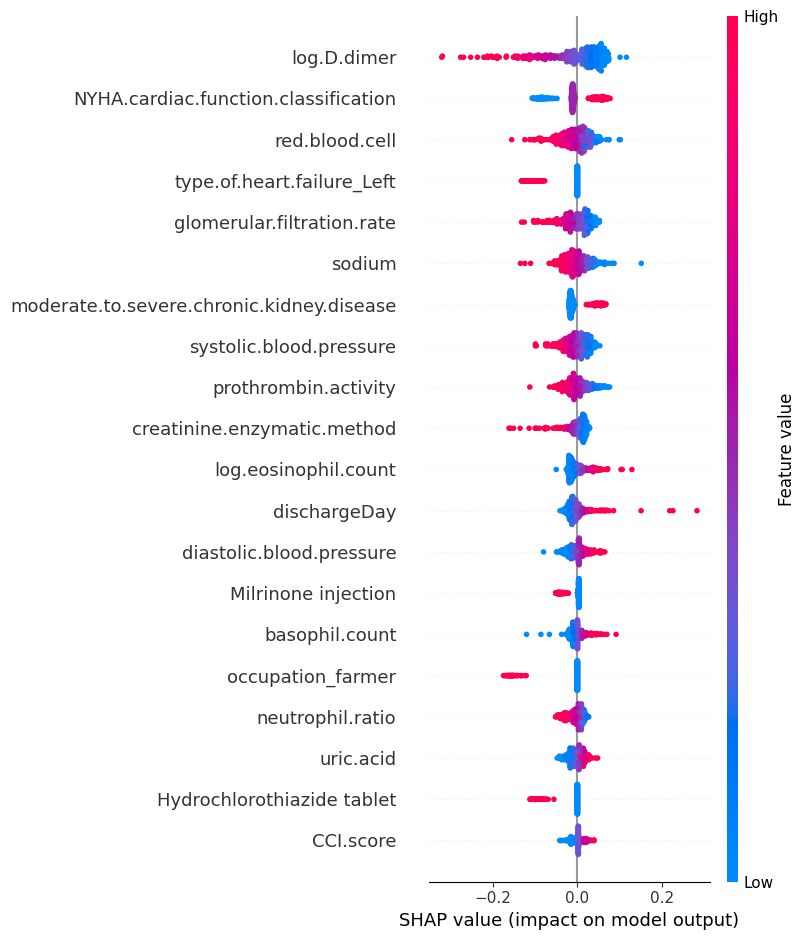

In [ ]:
shap.summary_plot(shap_values[1], x_test_)

The plot displays the features along the y-axis, ranked in descending order based on their importance. 

In [ ]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    
    '''
    A function for building a SHAP waterfall plot.
    
    SHAP waterfall plot is used to visualize the most important features in a descending order.
    
    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display
    
    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot
    
    '''
    
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 2))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

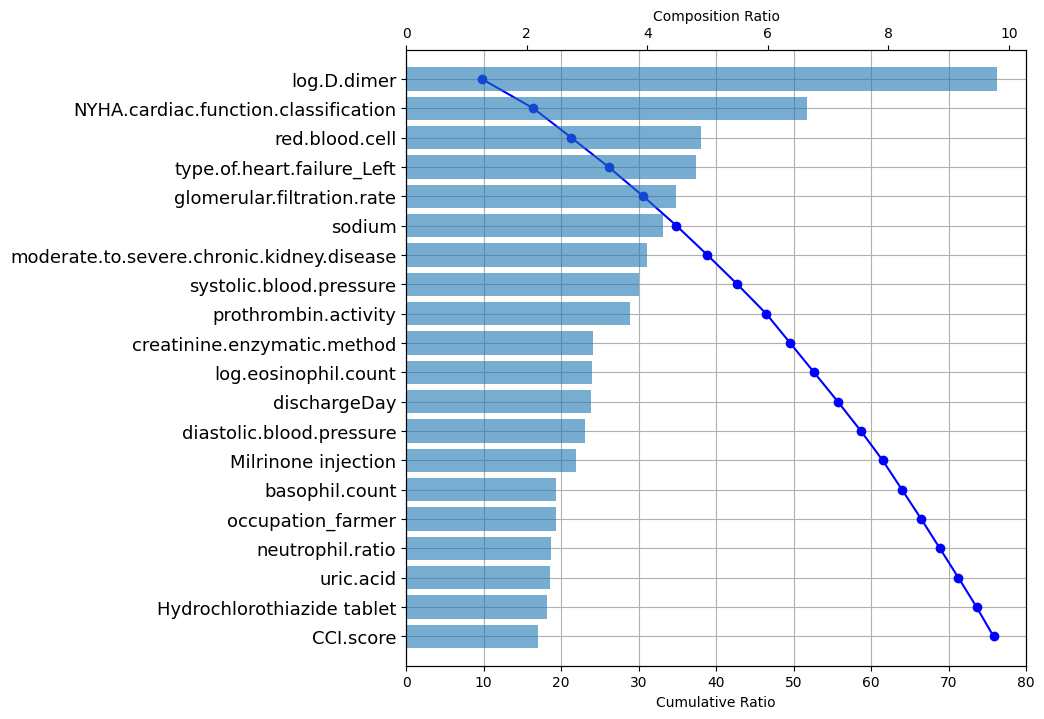

In [ ]:
# Shapp waterfall plot
make_shap_waterfall_plot(shap_values[1], x_test_)

Based on the SHAP waterfall plot, we can say that the log.D.dimer is the most important feature in the model, which has more than 8% of the model's explainability. Also, these top 20 features provide more than 80% of the model's interpretation.

### LIME

In [ ]:
# LIME EXPLAINATION FOR A SPECIFIC INSTANCE
explanation  = explainer_lime.explain_instance(x_test.iloc[[i-5]].values[0], model.predict_proba)

# Interpret the explanation
explanation.show_in_notebook()

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names


### Permutation importance
Decrease in a model score when a single variable is shuffled [1. L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.]


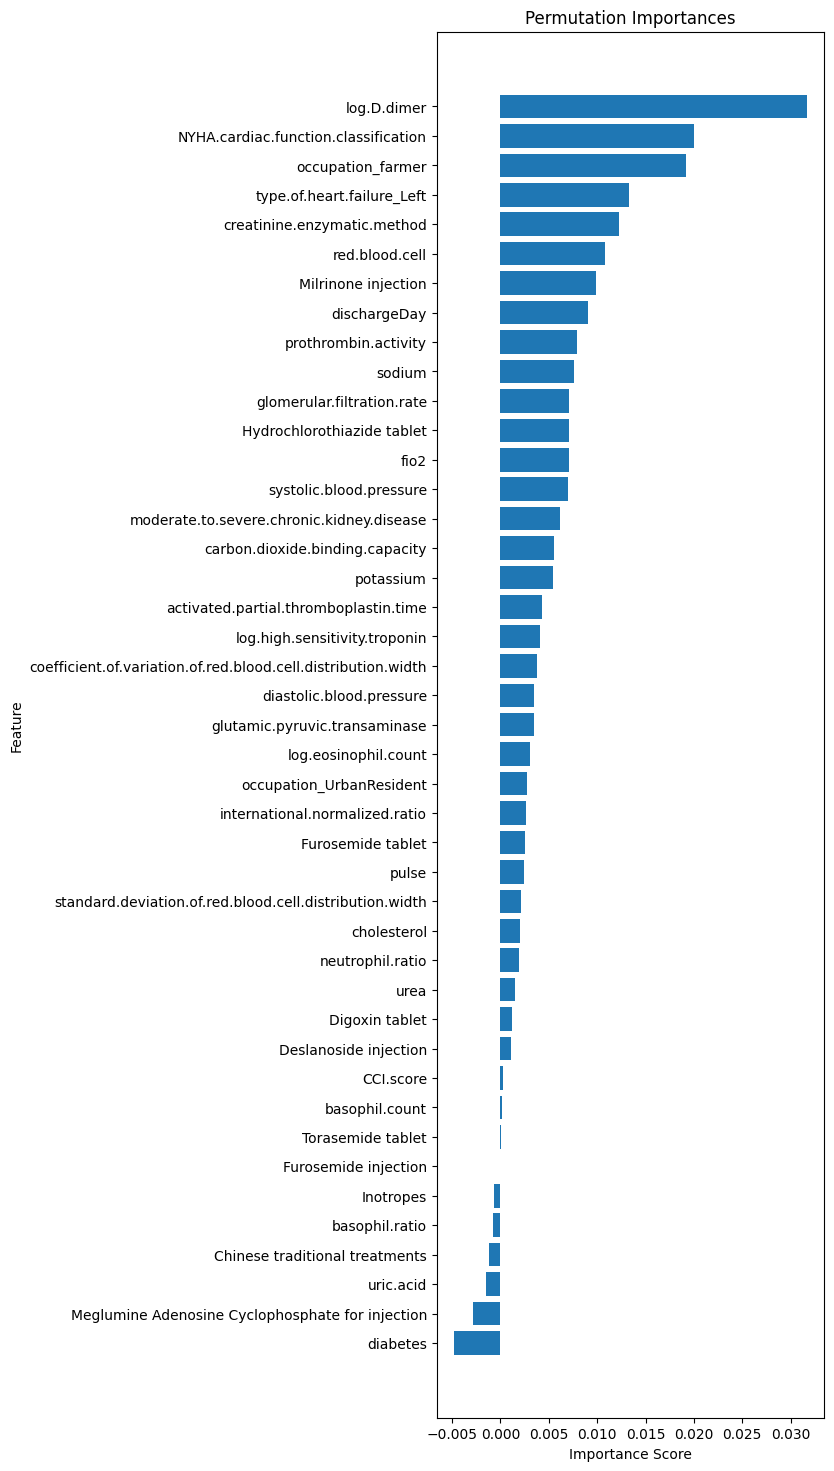

In [ ]:
from sklearn.inspection import permutation_importance

permutation_output = permutation_importance(model, x_train, y_train, n_repeats = 10, random_state = 42)
imp_means = permutation_output.importances_mean
idx_to_sort_output = (imp_means.argsort())

plt.figure(figsize = (5, 18))
plt.barh(range(len(imp_means[idx_to_sort_output])), imp_means[idx_to_sort_output], tick_label=x_train.columns[idx_to_sort_output])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Permutation Importances") 
plt.show()

Text(0.5, 0, 'Importance Score')

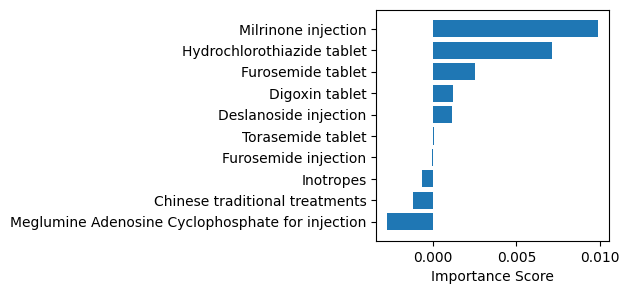

In [ ]:
#drugs only
drug_totest = ['Furosemide tablet', 'Meglumine Adenosine Cyclophosphate for injection', 'Furosemide injection', 'Milrinone injection', 'Deslanoside injection' ,'Torasemide tablet',
                  'Digoxin tablet', 'Hydrochlorothiazide tablet', 'Inotropes', 'Chinese traditional treatments']
drugs_importance_scores = imp_means[np.isin(x_train.columns, drug_totest)]
idx_to_sort= drugs_importance_scores.argsort()

plt.figure(figsize = (3,3))
plt.barh(range(len(drugs_importance_scores)), drugs_importance_scores[idx_to_sort], tick_label = np.array(drug_totest)[idx_to_sort])
plt.xlabel("Importance Score") 

# Ensemble MRMR

In [ ]:
# Loading data
x_train = pd.read_csv('Data/mrmr_train.csv').drop(['Unnamed: 0'], axis=1)
x_test = pd.read_csv('Data/mrmr_test.csv').drop(['Unnamed: 0'], axis=1)

y_train = pd.read_csv('Data/mrmr_y_train.csv').drop(['Unnamed: 0'], axis=1).values.flatten()
y_test = pd.read_csv('Data/mrmr_y_test.csv').drop(['Unnamed: 0'], axis=1).values.flatten()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(x_train.columns)
print((x_train.columns == x_test.columns).all())

(1576, 22)
(390, 22)
(1576,)
(390,)
Index(['type.of.heart.failure_Left', 'NYHA.cardiac.function.classification',
       'dischargeDay', 'occupation_farmer', 'log.D.dimer',
       'Hydrochlorothiazide tablet', 'basophil.count',
       'moderate.to.severe.chronic.kidney.disease', 'systolic.blood.pressure',
       'cholesterol', 'uric.acid', 'log.eosinophil.count', 'Inotropes',
       'CCI.score', 'basophil.ratio', 'sodium', 'glomerular.filtration.rate',
       'Furosemide tablet', 'prothrombin.activity', 'Furosemide injection',
       'red.blood.cell', 'Digoxin tablet'],
      dtype='object')
True


In [ ]:
# LIME 
explainer_lime = LimeTabularExplainer(x_train.values, feature_names = x_train.columns.tolist(), class_names = [0,1], mode = 'classification')

# SHAPE 
# rather than use the whole training set to estimate expected values, we summarize with
# a set of weighted kmeans, each weighted by the number of points they represent.
X_train_summary = shap.kmeans(x_train, 10)

def print_accuracy(f):
    print("Accuracy = {0}%".format(100*np.sum(f(x_test) == y_test)/len(y_test)))
    time.sleep(0.5) # to let the print get out before any progress bars

shap.initjs()

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [ ]:
# Get the model
model_path = 'models/ensemble_mrmr_soft.pkl'
with open(model_path, 'rb') as file:  model = pickle.load(file)

### SHAP

In [ ]:
i = 82
#x_test_ = x_test.iloc[i-10:i+10,:]
x_test_ = x_test

In [ ]:
# explain all the predictions in the test set
print_accuracy(model.predict)
explainer_shap = shap.KernelExplainer(model.predict_proba, X_train_summary)
shap_values = explainer_shap.shap_values(x_test_)

Accuracy = 65.8974358974359%


X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/390 [00:00<?, ?it/s]

X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but MLPClassifier was fitted with feature names
X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
X does not have valid feature names, but SV

In [ ]:
with open('models/shap_expl_ensemble_mrmr.pkl', 'wb') as file: pickle.dump(shap_values,file) 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


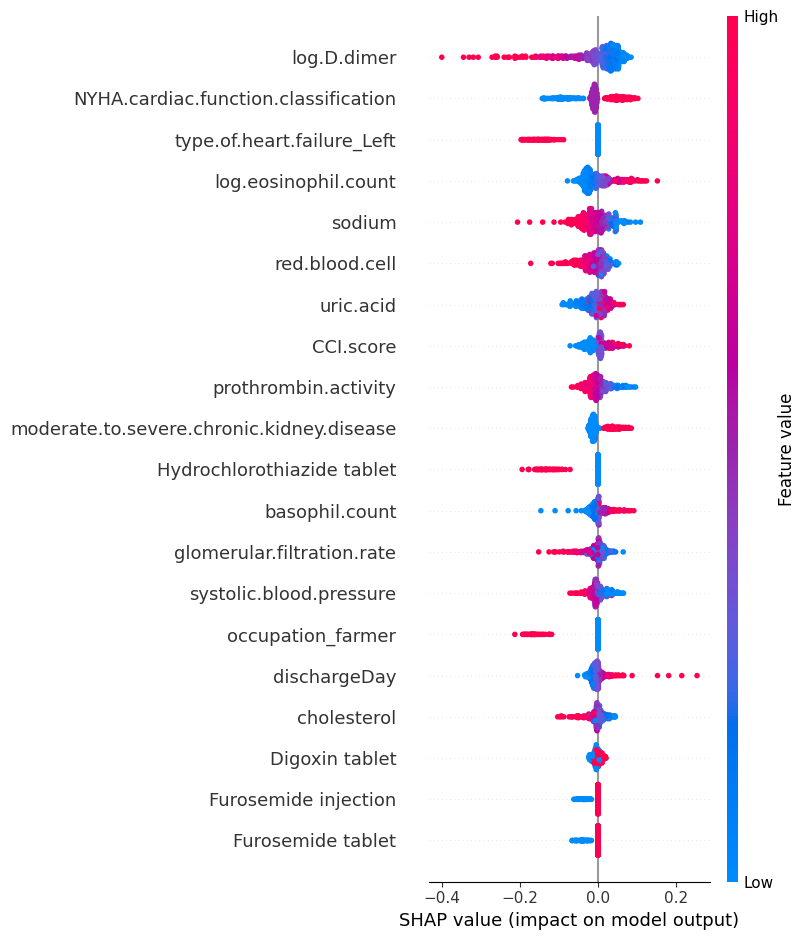

In [ ]:
shap.summary_plot(shap_values[1], x_test_)

Positive SHAP value means positive impact on prediction, leading the model to predict 1. Negative SHAP value means negative impact, leading the model to predict 0. The plot displays the features along the y-axis, ranked in descending order based on their importance. 

In [ ]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    
    '''
    A function for building a SHAP waterfall plot.
    
    SHAP waterfall plot is used to visualize the most important features in a descending order.
    
    Parameters:
    shap_values (list): SHAP values obtained from a model
    features (pandas DataFrame): a list of features used in a model
    num_display(int): number of features to display
    
    Returns:
    matplotlib.pyplot plot: SHAP waterfall plot
    
    '''
    
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 2))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))

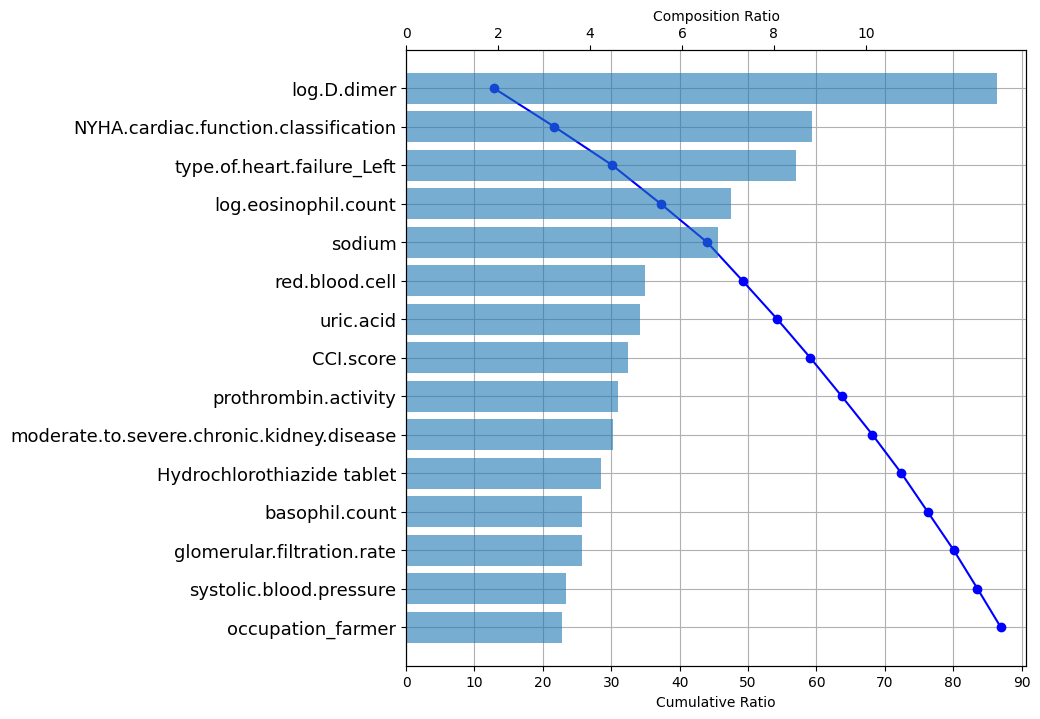

In [ ]:
# Shapp waterfall plot
make_shap_waterfall_plot(shap_values[1], x_test_, num_display=15)

Based on the SHAP waterfall plot, we can say that the log.D.dimer is the most important feature in the model, which has more than 8% of the model's explainability. Also, these top 20 features provide more than 80% of the model's interpretation.

### Permutation importance
Decrease in a model score when a single variable is shuffled [1. L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.]


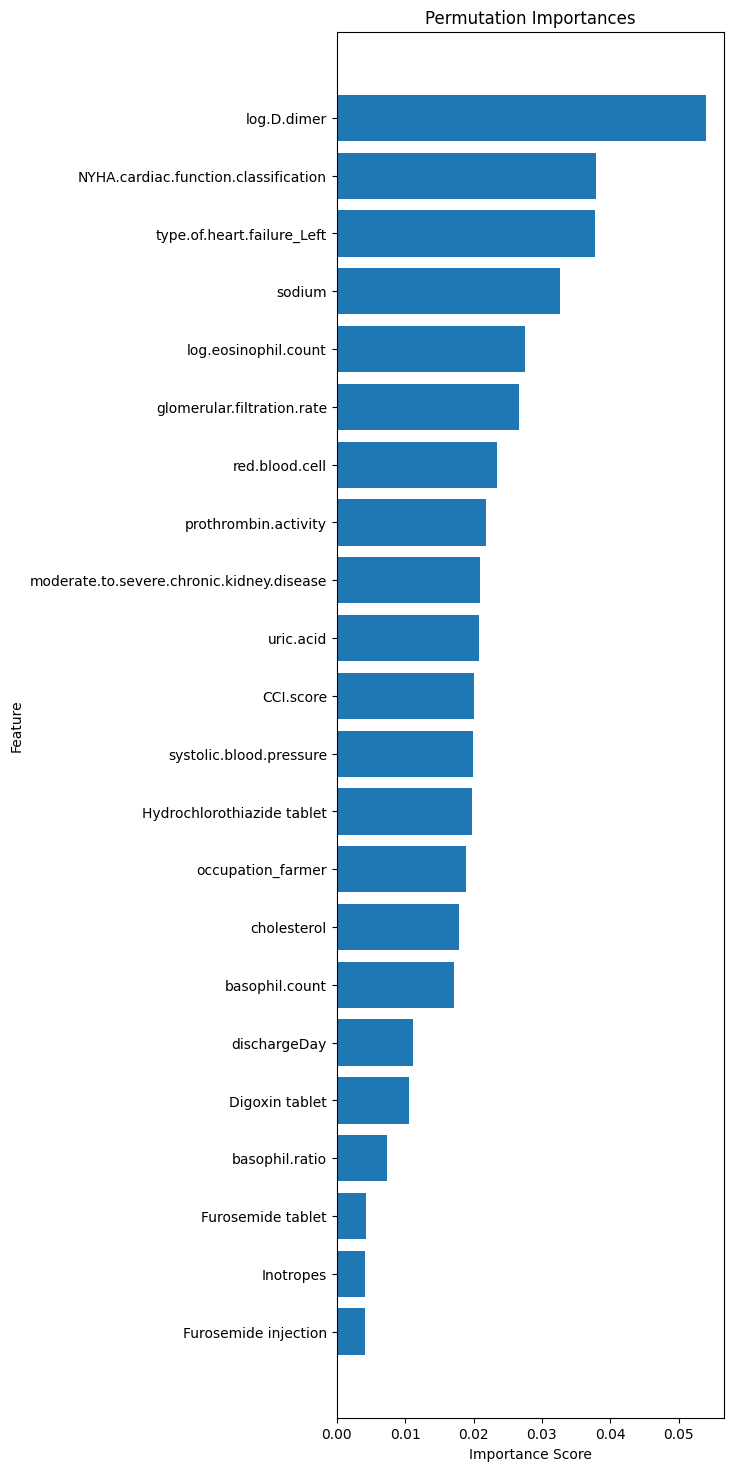

In [ ]:
from sklearn.inspection import permutation_importance

permutation_output = permutation_importance(model, x_train, y_train, n_repeats = 10, random_state = 42)
imp_means = permutation_output.importances_mean
idx_to_sort_output = (imp_means.argsort())

plt.figure(figsize = (5, 18))
plt.barh(range(len(imp_means[idx_to_sort_output])), imp_means[idx_to_sort_output], tick_label=x_train.columns[idx_to_sort_output])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Permutation Importances") 
plt.show()